### Importing Libraries

In [1]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

### Loading and Preprocessing the Data

In [2]:
transform = transforms.ToTensor()
path = './'
mnist_dataset = torchvision.datasets.MNIST(root=path, train=True,transform=transform, download=True)
mnist_valid_dataset = torch.utils.data.Subset(mnist_dataset,torch.arange(20000))
mnist_train_dataset = torch.utils.data.Subset(mnist_dataset,torch.arange(20000, len(mnist_dataset)))
mnist_test_dataset = torchvision.datasets.MNIST(root=path, train=False,transform=transform, download=False)
print('number of items in mnist_dataset:', len(mnist_dataset))
print('number of items in mnist_train_dataset:', len(mnist_train_dataset))
print('number of items in mnist_valid_dataset:', len(mnist_valid_dataset))
print('number of items in mnist_test_dataset:', len(mnist_test_dataset))

number of items in mnist_dataset: 60000
number of items in mnist_train_dataset: 40000
number of items in mnist_valid_dataset: 20000
number of items in mnist_test_dataset: 10000


In [3]:
batch_size = 2
torch.manual_seed(1)
train_dl = DataLoader(mnist_train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(mnist_valid_dataset, batch_size, shuffle=False)

### Implementing the CNN Model using the torch.nn module

In [4]:
x = torch.ones((1, 1, 28, 28))
model = nn.Sequential()
model.add_module('conv1',nn.Conv2d(in_channels=1, out_channels=4,kernel_size=3,stride=1 ,padding=0))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2,stride=2))
print(model(x).shape)
model.add_module('conv2',nn.Conv2d(in_channels=4, out_channels=2,kernel_size=3, stride=3,padding=0))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=4,stride=4))
print(model(x).shape)

torch.Size([1, 4, 13, 13])
torch.Size([1, 2, 1, 1])


In [5]:
model.add_module('flatten', nn.Flatten())

model.add_module('fc1', nn.Linear(2,10))
print(model(x).shape)

torch.Size([1, 10])


In [6]:
device = torch.device("cpu")

model = model.to(device) 

In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Model Evaluation using Training Data

def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device) 
            y_batch = y_batch.to(device) 
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device) 
                y_batch = y_batch.to(device) 
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0) 
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float() 
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()
        
        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

torch.manual_seed(1)
num_epochs = 5
hist = train(model, num_epochs, train_dl, valid_dl)

C:\Users\rahul\AppData\Roaming\Python\Python39\site-packages\torch\autograd\__init__.py:173: UserWarning: CUDA initialization: CUDA driver initialization failed, you might not have a CUDA gpu. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\cuda\CUDAFunctions.cpp:112.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1 accuracy: 0.1103 val_accuracy: 0.1141
Epoch 2 accuracy: 0.1110 val_accuracy: 0.1141
Epoch 3 accuracy: 0.1109 val_accuracy: 0.1141
Epoch 4 accuracy: 0.1107 val_accuracy: 0.1141
Epoch 5 accuracy: 0.1112 val_accuracy: 0.1141


### Plotting the Accuracy and Loss Curves

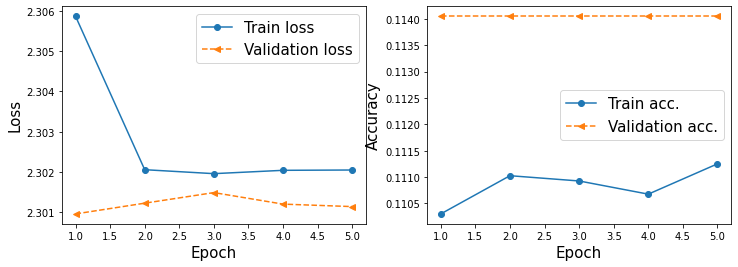

In [8]:
x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

In [9]:
## Model Evaluation using Testing Data

model_cpu = model.cpu()
pred = model(mnist_test_dataset.data.unsqueeze(1) / 255.)
is_correct = (torch.argmax(pred, dim=1) == mnist_test_dataset.targets).float()
print(f'Test accuracy: {is_correct.mean():.4f}') 

Test accuracy: 0.1135


### Testing the Model with changes in the parameters.

torch.Size([1, 32, 14, 14])
torch.Size([1, 64, 7, 7])
torch.Size([1, 1024])
torch.Size([1, 10])
Epoch 1 accuracy: 0.9402 val_accuracy: 0.9808
Epoch 2 accuracy: 0.9823 val_accuracy: 0.9839
Epoch 3 accuracy: 0.9883 val_accuracy: 0.9876
Epoch 4 accuracy: 0.9898 val_accuracy: 0.9869
Epoch 5 accuracy: 0.9931 val_accuracy: 0.9900


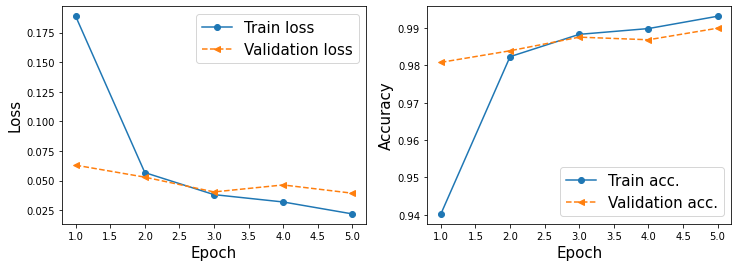

Test accuracy: 0.9913


In [10]:
batch_size = 64
torch.manual_seed(1)
train_dl = DataLoader(mnist_train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(mnist_valid_dataset, batch_size, shuffle=False)

x = torch.ones((1, 1, 28, 28))
model = nn.Sequential()
model.add_module('conv1',nn.Conv2d(in_channels=1, out_channels=32,kernel_size=5,stride=1 ,padding=2))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
print(model(x).shape)
model.add_module('conv2',nn.Conv2d(in_channels=32, out_channels=64,kernel_size=5 ,padding=2))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))
print(model(x).shape)

model.add_module('flatten', nn.Flatten())

model.add_module('fc1', nn.Linear(3136,1024))
print(model(x).shape) 
model.add_module('relu3', nn.ReLU())
model.add_module('dropout', nn.Dropout(p=0.5))
model.add_module('fc2', nn.Linear(1024, 10))
print(model(x).shape)

device = torch.device("cpu")

model = model.to(device) 

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Model Evaluation using Training Data

def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device) 
            y_batch = y_batch.to(device) 
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device) 
                y_batch = y_batch.to(device) 
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0) 
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float() 
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()
        
        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

torch.manual_seed(1)
num_epochs = 5
hist = train(model, num_epochs, train_dl, valid_dl)

## Plotting the Loss and Accuracy

x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

## Model Evaluation using Testing Data

model_cpu = model.cpu()
pred = model(mnist_test_dataset.data.unsqueeze(1) / 255.)
is_correct = (torch.argmax(pred, dim=1) == mnist_test_dataset.targets).float()
print(f'Test accuracy: {is_correct.mean():.4f}') 